In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import utils
import torch
from sklearn.model_selection import train_test_split
import pickle
# train svm, lr
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
from model import Model

In [3]:
%load_ext autoreload
%autoreload 2

# Load data

In [65]:
config = utils.read_config()
# set seeds
utils.set_seeds(config['seed'])
behaviour_data_all, spikes, trial_indices = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data_all, spikes = [x[time_from:, :] for x in behaviour_data_all], [x[time_from:, :] for x in spikes]
stim_idx, choice_idx, amp_idx, prev_choice_idx = 9, 3, 24, 6
stim = [x[0, stim_idx] for x in behaviour_data_all]
choice = [x[0, choice_idx] for x in behaviour_data_all]
prev_choice = [x[0, prev_choice_idx] for x in behaviour_data_all]
amp = torch.tensor([x[:, amp_idx] for x in behaviour_data_all], dtype=torch.float32)
# normalize amp by max value
amp = amp / amp.max()
num_contacts = [np.sum(x[:, 15:19], axis=1) for x in behaviour_data_all]
# concat them
behaviour_data = np.stack((stim, choice, prev_choice), axis=1)
# convert to torch tensors
behaviour_data = np.array(behaviour_data)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = np.array(spikes)
num_trials, time_bins, emissions_dim = spikes.shape
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, amp_train, amp_test = train_test_split(behaviour_data, spikes, amp, test_size=0.2, random_state=7)
trials_train, trials_test = len(behaviour_data_train), len(behaviour_data_test)
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_train[:, 0]), np.mean(behaviour_data_train[:, 1]), np.mean(behaviour_data_train[:, 2])))
print("Test distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_test[:, 0]), np.mean(behaviour_data_test[:, 1]), np.mean(behaviour_data_test[:, 2])))
# labels
y_stim_train, y_stim_test = behaviour_data_train[:, 0], behaviour_data_test[:, 0]
y_choice_train, y_choice_test = behaviour_data_train[:, 1], behaviour_data_test[:, 1]
y_prev_choice_train, y_prev_choice_test = behaviour_data_train[:, 2], behaviour_data_test[:, 2]

Train distribution of Stimulus: 0.46875, Choice: 0.359375, Prev Choice: 0.453125
Test distribution of Stimulus: 0.5454545454545454, Choice: 0.48484848484848486, Prev Choice: 0.3333333333333333


# Train simple models on spikes for upper bound

Max test accuracy (stimulus): 0.6666666666666666
Max test accuracy (choice): 0.9393939393939394


Text(0.5, 1.0, 'SVM')

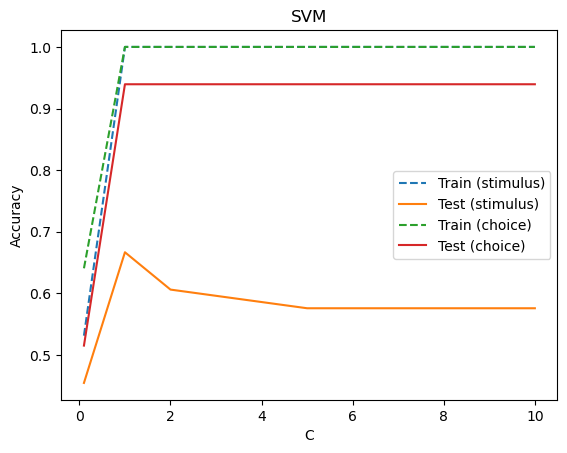

In [5]:
train_acc_stim, test_acc_stim = [], []
train_acc_choice, test_acc_choice = [], []
list_c = [0.1, 1, 2, 5, 10]
for which_beh, y_train, y_test in [('stim', y_stim_train, y_stim_test), ('choice', y_choice_train, y_choice_test)]:
    for c in list_c:
        # train svm
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        clf.fit(spikes_train.reshape(spikes_train.shape[0], -1), y_train)
        # predict
        pred_test = clf.predict(spikes_test.reshape(spikes_test.shape[0], -1))
        pred_train = clf.predict(spikes_train.reshape(spikes_train.shape[0], -1))
        # calculate accuracy
        test_accuracy = accuracy_score(y_test, pred_test)
        train_accuracy = accuracy_score(y_train, pred_train)
        if which_beh == 'stim':
            train_acc_stim.append(train_accuracy)
            test_acc_stim.append(test_accuracy)
        else:
            train_acc_choice.append(train_accuracy)
            test_acc_choice.append(test_accuracy)
# plot
plt.plot(list_c, train_acc_stim, label='Train (stimulus)', linestyle='--')
plt.plot(list_c, test_acc_stim, label='Test (stimulus)')
plt.plot(list_c, train_acc_choice, label='Train (choice)', linestyle='--')
plt.plot(list_c, test_acc_choice, label='Test (choice)')
# print max test accuracy
max_test_acc_stim = np.max(test_acc_stim)
max_test_acc_choice = np.max(test_acc_choice)
print("Max test accuracy (stimulus): {}".format(max_test_acc_stim))
print("Max test accuracy (choice): {}".format(max_test_acc_choice))

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM')


# Stimulus and Choice decoding from single/multiple bins

Max train accuracy (choice; C=0.5): 0.9375
Max test accuracy (choice; C=0.5): 0.9090909090909091

Max train accuracy (choice; C=1): 0.984375
Max test accuracy (choice; C=1): 0.9090909090909091

Max train accuracy (choice; C=5): 1.0
Max test accuracy (choice; C=5): 0.8787878787878788

Max train accuracy (choice; C=10): 1.0
Max test accuracy (choice; C=10): 0.8787878787878788



Text(0.5, 1.0, 'Test accuracy for different time bins for choice; window = 5')

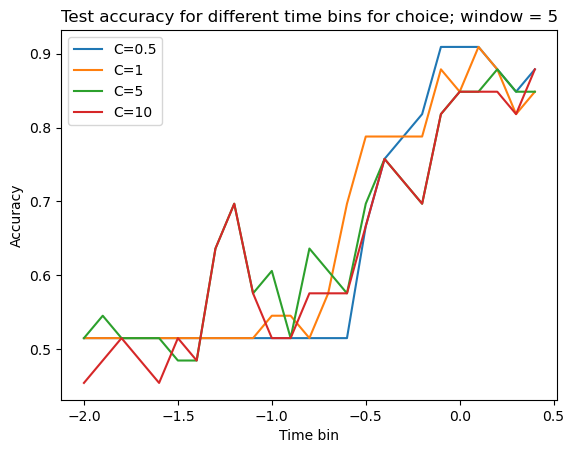

In [7]:
one_sided_window = 2
spikes_train_ = np.concatenate([np.zeros((len(spikes_train), one_sided_window, emissions_dim)), spikes_train, np.zeros((len(spikes_train), one_sided_window, emissions_dim))], axis=1)
spikes_test_ = np.concatenate([np.zeros((len(spikes_test), one_sided_window, emissions_dim)), spikes_test, np.zeros((len(spikes_test), one_sided_window, emissions_dim))], axis=1)
# behavior = 'stimulus'
behavior = 'choice'
list_c = [0.5, 1, 5, 10]
x = np.arange(25)/10 - 2
if behavior == 'stimulus':
    y_train, y_test = y_stim_train, y_stim_test
else:
    y_train, y_test = y_choice_train, y_choice_test
for c in list_c:
    train_acc, test_acc = [], []
    for t in range(25):
        # train svm
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        x_train = spikes_train_[:, t: t+2*one_sided_window+1].reshape(spikes_train_.shape[0], -1)
        x_test = spikes_test_[:, t: t+2*one_sided_window+1].reshape(spikes_test_.shape[0], -1)        
        clf.fit(x_train, y_train)
        # predict
        pred_test = clf.predict(x_test)
        pred_train = clf.predict(x_train)
        # calculate accuracy
        test_accuracy = accuracy_score(y_test, pred_test)
        train_accuracy = accuracy_score(y_train, pred_train)        
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    # plot
    # plt.plot(list_c, train_acc_stim, label='Train (stimulus)', linestyle='--')
    plt.plot(x, test_acc, label='C={}'.format(c))
    # print max    
    print("Max train accuracy ({}; C={}): {}".format(behavior, c, np.max(train_acc)))
    print("Max test accuracy ({}; C={}): {}\n".format(behavior, c, np.max(test_acc)))

plt.xlabel('Time bin')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test accuracy for different time bins for {}; window = {}'.format(behavior, one_sided_window*2+1))


# Load model output

In [62]:
config = utils.read_config()
model = Model(config, input_dim=emissions_dim)
print(model.arch_name)
# folder_pth = 'results/dandi_sub-221CR_ses-20190515T160400/100_ms/'
folder_pth = 'results/dandi_sub-221CR_ses-20190515T160400/100_ms/'
# prefix = '1simplevae_'
# prefix = '2vaegp_'
# prefix = '3monotonicity_'
# prefix = '3monotonicitybest_'
prefix = ''
with open(folder_pth + prefix + model.arch_name + '/res.pkl', 'rb') as f:
    all_data = pickle.load(f)
x_mu_train, z_mu_train, x_mu_test, z_mu_test = all_data[1], all_data[2], all_data[10], all_data[11]
x_samp_train, z_samp_train = all_data[5], all_data[6]
x_samp_test, z_samp_test = all_data[14], all_data[15]
x_cov, z_cov = all_data[3], all_data[4]
y_recon_train, y_recon_test = all_data[0], all_data[9]
x_mu_train, x_mu_test = x_mu_train.reshape(trials_train, time_bins, -1), x_mu_test.reshape(trials_test, time_bins, -1)
z_presoftmax_train, z_presoftmax_test = all_data[7], all_data[16]
amp_train_pred, amp_test_pred = all_data[-2], all_data[-1]

Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable parameters in Posterior Mean: 190
Number of trainable parameters in Block Diagonal Z: 163
Number of trainable parameters in Cov X: 217
Number of trainable parameters in VAE: 3217
Using choice decoder
Using amplitude decoder
Scheduler not implemented for decoder
Number of trainable parameters in behavior decoder: 123
vae_gp_[1, 1, 1]_diagonal_gru_8_2_True_noise_0.01_rbfscale_0.5_smoothing_3_monotonic_1_1_10_[True, True, False]_3_entropy_Nonecnn_None_1_0


Text(0.5, 1.0, 'x_mu and x_sample for a random trial (train)')

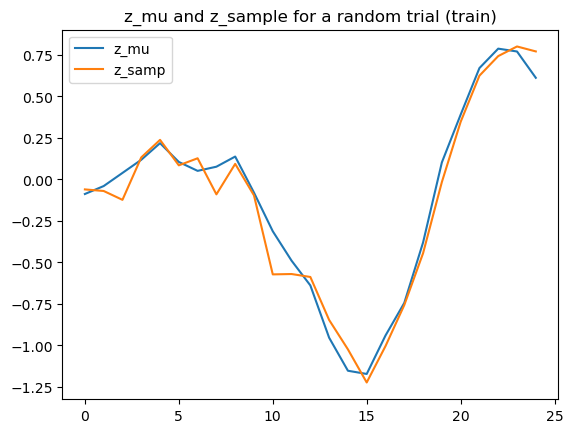

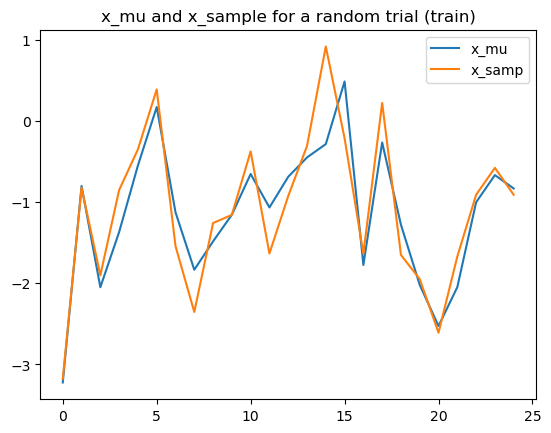

In [10]:
# plot z_mu_train and z_sample_train for a random trial
trial_idx = np.random.randint(trials_train)
plt.figure()
plt.plot(z_mu_train[trial_idx, :, 1], label='z_mu')
plt.plot(z_presoftmax_train[trial_idx, :, 1], label='z_samp')
plt.legend()
plt.title('z_mu and z_sample for a random trial (train)')
# plot x_mu_train and x_samp_train for a random trial
plt.figure()
plt.plot(x_mu_train[trial_idx, :, 1], label='x_mu')
plt.plot(x_samp_train[trial_idx, :, 1], label='x_samp')
plt.legend()
plt.title('x_mu and x_sample for a random trial (train)')


# For each latent z, zero out time bins where z is not the argmax

Data:
* spikes: trials x bins x neurons
* x: trials x bins x x_dim
* z: trials x bins x 3/2

In [ ]:
decoding_from = 'spikes' # spikes or mu
# decoding_from = 'mu' # spikes or mu
# Thresholding based on z to keep only relevant time bins
z_dim = z_mu_train.shape[-1]
argmax_z_train = np.argmax(z_mu_train, axis=2)
argmax_z_test = np.argmax(z_mu_test, axis=2)

# y_train, y_test = y_stim_train, y_stim_test
y_train, y_test = y_choice_train, y_choice_test
# y_train, y_test = y_prev_choice_train, y_prev_choice_test

list_c = [0.1, 0.5, 1, 2, 5, 10]

for i in range(z_dim):
    # set spikes where z is not i to 0
    if decoding_from == 'spikes':
        x_train, x_test = spikes_train.copy(), spikes_test.copy()
    else:
        x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    x_train[argmax_z_train != i] = 0
    x_test[argmax_z_test != i] = 0
    # # take only first 10 time bins
    # x_train, x_test = x_train[:, :10], x_test[:, :10]
    # print number of bins kept
    print("Number of time bins kept for z = {}: {}".format(i, np.mean(argmax_z_train == i)))
    for c in list_c:
        # train svm        
        clf = SVC(C=c)
        clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
        # predict
        pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
        pred_train = clf.predict(x_train.reshape(x_train.shape[0], -1))
        # calculate accuracy
        test_accuracy = round(accuracy_score(y_test, pred_test), 3)
        train_accuracy = round(accuracy_score(y_train, pred_train), 3)
        print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))


# For each latent z, zero out time bins where z < threshold

In [ ]:
# y_train, y_test = y_stim_train, y_stim_test
y_train, y_test = y_choice_train, y_choice_test
threshold = 0.4

for i in range(z_dim):
    # set spikes where z < 0.5 to 0
    # x_train, x_test = spikes_train.copy(), spikes_test.copy()
    x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    x_train[z_mu_train[:, :, i] < threshold] = 0
    x_test[z_mu_test[:, :, i] < threshold] = 0
    # print number of bins kept
    print("Number of time bins kept for z = {}: {}".format(i, np.mean(z_mu_train[:, :, i] >= threshold)))
    # train svm
    clf = SVC(C=1)
    clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
    # predict
    pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
    # calculate accuracy
    test_accuracy = accuracy_score(y_test, pred_test)
    print("Test accuracy (stimulus) after thresholding z: {}".format(test_accuracy))

# Train and test on time bin surrounding peak z

In [ ]:
decoding_from = 'spikes' # spikes or mu
# decoding_from = 'mu' # spikes or mu
# Thresholding based on z to keep only relevant time bins
z_dim = z_mu_train.shape[-1]
x_dim = x_mu_train.shape[-1]

# y_train, y_test = y_stim_train, y_stim_test
y_train, y_test = y_choice_train, y_choice_test
# y_train, y_test = y_prev_choice_train, y_prev_choice_test

list_c = [0.1, 0.5, 1, 2, 5]
one_sided_window = 1
# concatenate spikes with one sided window on both sides with zeros
spikes_train_ = np.concatenate([np.zeros((len(spikes_train), one_sided_window, emissions_dim)), spikes_train, np.zeros((len(spikes_train), one_sided_window, emissions_dim))], axis=1)
spikes_test_ = np.concatenate([np.zeros((len(spikes_test), one_sided_window, emissions_dim)), spikes_test, np.zeros((len(spikes_test), one_sided_window, emissions_dim))], axis=1)

for i in range(z_dim):
# for i in [1]:
    # set spikes where z is not i to 0
    if decoding_from == 'spikes':
        x_train, x_test = spikes_train_.copy(), spikes_test_.copy()
    else:
        x_train = np.concatenate([np.zeros((len(x_mu_train), one_sided_window, x_dim)), x_mu_train, np.zeros((len(x_mu_train), one_sided_window, x_dim))], axis=1)
        x_test = np.concatenate([np.zeros((len(x_mu_test), one_sided_window, x_dim)), x_mu_test, np.zeros((len(x_mu_test), one_sided_window, x_dim))], axis=1)        
    # print(x_train.shape, x_test.shape)
    # find time bin where z peaks
    argmax_z_train = np.argmax(z_mu_train[:, :, i], axis=1)
    # print(argmax_z_train)
    argmax_z_test = np.argmax(z_mu_test[:, :, i], axis=1)    
    # take one sided window
    x_train = np.array([x[argmax_z_train[j]:argmax_z_train[j]+2*one_sided_window+1] for j, x in enumerate(x_train)]).reshape(x_train.shape[0], -1)
    x_test = np.array([x[argmax_z_test[j]:argmax_z_test[j]+2*one_sided_window+1] for j, x in enumerate(x_test)]).reshape(x_test.shape[0], -1)
    
    for c in list_c:
        # train svm        
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        clf.fit(x_train, y_train)
        # predict
        pred_test = clf.predict(x_test)
        pred_train = clf.predict(x_train)
        # calculate accuracy
        test_accuracy = round(accuracy_score(y_test, pred_test), 3)
        train_accuracy = round(accuracy_score(y_train, pred_train), 3)
        print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))
    print("")


# Filter trials based on peak of z0

In [ ]:
def filter(z):
    # z is of shape trials x time_bins    
    mask = z[:, :10].max(axis=1) > 0.5
    return mask
softmax = torch.nn.Softmax(dim=2)
z_mu_train_s = softmax(torch.tensor(z_mu_train, dtype=torch.float32)).numpy()
z_mu_test_s = softmax(torch.tensor(z_mu_test, dtype=torch.float32)).numpy()
train_mask, test_mask = filter(z_mu_train_s[:, :, 1]), filter(z_mu_test_s[:, :, 1])
# keep only these trials
x_mu_train, x_mu_test = x_mu_train[train_mask], x_mu_test[test_mask]
y_stim_train, y_stim_test = y_stim_train[train_mask], y_stim_test[test_mask]
y_choice_train, y_choice_test = y_choice_train[train_mask], y_choice_test[test_mask]
y_prev_choice_train, y_prev_choice_test = y_prev_choice_train[train_mask], y_prev_choice_test[test_mask]
spikes_train, spikes_test = spikes_train[train_mask], spikes_test[test_mask]
z_mu_train, z_mu_test = z_mu_train[train_mask], z_mu_test[test_mask]

chance_choice = max(np.mean(y_choice_test), 1 - np.mean(y_choice_test))
chance_stim = max(np.mean(y_stim_test), 1 - np.mean(y_stim_test))
chance_prev_choice = max(np.mean(y_prev_choice_test), 1 - np.mean(y_prev_choice_test))

print("Chance level for choice: {}".format(chance_choice))
print("Chance level for stimulus: {}".format(chance_stim))
print("Chance level for prev choice: {}".format(chance_prev_choice))

In [ ]:
print(train_mask.sum(), len(train_mask), test_mask.sum(), len(test_mask))
# print all indices where mask is True
# print(np.where(train_mask)[0])
print(spikes_train.shape, y_choice_train.shape)

In [ ]:
# decoding_from = 'spikes' # spikes or mu
decoding_from = 'mu' # spikes or mu
one_sided_window = 2
spikes_train_ = np.concatenate([np.zeros((len(spikes_train), one_sided_window, emissions_dim)), spikes_train, np.zeros((len(spikes_train), one_sided_window, emissions_dim))], axis=1)
spikes_test_ = np.concatenate([np.zeros((len(spikes_test), one_sided_window, emissions_dim)), spikes_test, np.zeros((len(spikes_test), one_sided_window, emissions_dim))], axis=1)
# spikes_train_ = np.concatenate([np.zeros((len(y_recon_train), one_sided_window, emissions_dim)), y_recon_train, np.zeros((len(y_recon_train), one_sided_window, emissions_dim))], axis=1)
# spikes_test_ = np.concatenate([np.zeros((len(y_recon_test), one_sided_window, emissions_dim)), y_recon_test, np.zeros((len(y_recon_test), one_sided_window, emissions_dim))], axis=1)
x = np.arange(25)/10 - 2
colors = ['r', 'b']
C = 1
for i, (behave, y_train, y_test) in enumerate(zip(['current choice', 'prev choice'], [y_choice_train, y_prev_choice_train], [y_choice_test, y_prev_choice_test])):
    train_acc, test_acc = [], []
    for t in range(25):
        # train svm
        clf = SVC(C=C)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        if decoding_from == 'spikes':
            x_train = spikes_train_[:, t: t+2*one_sided_window+1].reshape(spikes_train_.shape[0], -1)
            x_test = spikes_test_[:, t: t+2*one_sided_window+1].reshape(spikes_test_.shape[0], -1)
        else:
            x_train = np.concatenate([np.zeros((len(x_mu_train), one_sided_window)), x_mu_train[:, :, 1], np.zeros((len(x_mu_train), one_sided_window))], axis=1)
            x_test = np.concatenate([np.zeros((len(x_mu_test), one_sided_window)), x_mu_test[:, :, 1], np.zeros((len(x_mu_test), one_sided_window))], axis=1)        
            x_train = x_train[:, t: t+2*one_sided_window+1].reshape(x_train.shape[0], -1)
            x_test = x_test[:, t: t+2*one_sided_window+1].reshape(x_test.shape[0], -1)
        
        clf.fit(x_train, y_train)
        # predict
        pred_test = clf.predict(x_test)
        pred_train = clf.predict(x_train)
        # calculate accuracy
        # print(y_test.shape, pred_test.shape)
        test_accuracy = accuracy_score(y_test, pred_test)
        train_accuracy = accuracy_score(y_train, pred_train)        
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    # plot
    # plt.plot(list_c, train_acc_stim, label='Train (stimulus)', linestyle='--')
    plt.plot(x, test_acc, label=behave, color=colors[i])
    # print max    
    print("Max train accuracy ({}): {}".format(behave, np.max(train_acc)))
    print("Max test accuracy ({}): {}\n".format(behave, np.max(test_acc)))

# plot chance accuracies
plt.axhline(y=chance_choice, color='r', linestyle='--', label='Chance (choice)')
plt.axhline(y=chance_prev_choice, color='b', linestyle='--', label='Chance (prev choice)')
plt.xlabel('Time bin')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test accuracy using x1 for different time bins with window = {}'.format(one_sided_window*2+1))


# Relation to amplitude

In [ ]:
with open(folder_pth + prefix + model.arch_name +'/subspaces_filtered.pkl', 'rb') as f:
    lin_maps = pickle.load(f)

In [ ]:
mapping1, mapping2, mapping3 = lin_maps[0], lin_maps[1], lin_maps[2]

In [13]:
# do linear regression of amplitudes on spikes
# for all time bins
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [69]:
# spikes_train, spikes_test, amp_train, amp_test
# inputs
z_softmax = torch.nn.Softmax(dim=2)
z_mu_train_s = z_softmax(torch.tensor(z_mu_train, dtype=torch.float32)).numpy()
z_mu_test_s = z_softmax(torch.tensor(z_mu_test, dtype=torch.float32)).numpy()
# original spikes
inp_train = spikes_train.reshape(-1, spikes_train.shape[-1])#  * z_mu_train[:, :, 1].flatten()
inp_test = spikes_test.reshape(-1, spikes_test.shape[-1])# * z_mu_test[:, :, 1].flatten()
# reconstructed
# inp_train = y_recon_train.reshape(-1, y_recon_train.shape[-1])#  * z_mu_train[:, :, 1].flatten()
# inp_test = y_recon_test.reshape(-1, y_recon_test.shape[-1])# * z_mu_test[:, :, 1].flatten()
# x
# inp_train = x_mu_train[:, :, 0].flatten().reshape(-1, 1)
# inp_test = x_mu_test[:, :, 0].flatten().reshape(-1, 1)
# z
# inp_train = z_mu_train[:, :, 0].flatten().reshape(-1, 1)
# inp_test = z_mu_test[:, :, 0].flatten().reshape(-1, 1)
# softmax(z)
# inp_train = z_mu_train_s[:, :, 0].flatten().reshape(-1, 1)
# inp_test = z_mu_test_s[:, :, 0].flatten().reshape(-1, 1)
# x * z or x * softmax(z)
# inp_train = (x_mu_train[:, :, 0] * z_mu_train_s[:, :, 0]).flatten().reshape(-1, 1)
# inp_test = (x_mu_test[:, :, 0] * z_mu_test_s[:, :, 0]).flatten().reshape(-1, 1)
# inp_train = (x_mu_train[:, :, 2] * z_mu_train_s[:, :, 2]).flatten().reshape(-1, 1)
# inp_test = (x_mu_test[:, :, 2] * z_mu_test_s[:, :, 2]).flatten().reshape(-1, 1)
# x * softmax(z) * linear map

# print(x_mu_train[:, :, 0].shape, z_mu_train_s[:, :, 0].shape, lin_map.shape)

# using all
# inp_train = ((x_mu_train[:, :, 0:1] @ c0.T + b0) * z_mu_train_s[:, :, 0:1]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_train[:, :, 1:2] @ c2.T + b1) * z_mu_train_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_train[:, :, 2:3] @ c2.T + b2) * z_mu_train_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 0:1] @ c0.T + b0) * z_mu_test_s[:, :, 0:1]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_test[:, :, 1:2] @ c1.T + b1) * z_mu_test_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_test[:, :, 2:3] @ c2.T + b2) * z_mu_test_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])

# inp_train = ((x_mu_train[:, :, 0:1] @ c0.T + b0) * z_mu_train_s[:, :, 0:1]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_train[:, :, 1:2] @ c1.T + b1) * z_mu_train_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_train[:, :, 2:4] @ c2.T + b2) * z_mu_train_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 0:1] @ c0.T + b0) * z_mu_test_s[:, :, 0:1]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_test[:, :, 1:2] @ c1.T + b1) * z_mu_test_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_test[:, :, 2:4] @ c2.T + b2) * z_mu_test_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])

# using just 0
# inp_train = ((x_mu_train[:, :, 0:1] @ c0.T + b0) * z_mu_train_s[:, :, 0:1]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 0:1] @ c0.T + b0) * z_mu_test_s[:, :, 0:1]).flatten().reshape(-1, c0.shape[0])


# using rest but only 1 non null
# inp_train = ((x_mu_train[:, :, 1:2] @ c1.T + b1) * z_mu_train_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_train[:, :, 2:3] @ c2.T + b2) * z_mu_train_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 1:2] @ c1.T + b1) * z_mu_test_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_test[:, :, 2:3] @ c2.T + b2) * z_mu_test_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])

# 2 non-null
# inp_train = ((x_mu_train[:, :, 1:2] @ c1.T + b1) * z_mu_train_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_train[:, :, 2:4] @ c2.T + b2) * z_mu_train_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 1:2] @ c1.T + b1) * z_mu_test_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0]) + ((x_mu_test[:, :, 2:4] @ c2.T + b2) * z_mu_test_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])

# just z1
# inp_train = ((x_mu_train[:, :, 1:2] @ c1.T + b1) * z_mu_train_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 1:2] @ c1.T + b1) * z_mu_test_s[:, :, 1:2]).flatten().reshape(-1, c0.shape[0])

# just z2
# inp_train = ((x_mu_train[:, :, 2:4] @ c2.T + b2) * z_mu_train_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])
# inp_test = ((x_mu_test[:, :, 2:4] @ c2.T + b2) * z_mu_test_s[:, :, 2:3]).flatten().reshape(-1, c0.shape[0])

# amplitudes
# inp_train = amp_train_pred.flatten().reshape(-1, 1)
# inp_test = amp_test_pred.flatten().reshape(-1, 1)

# # apply softplus
# inp_train = np.log(1 + np.exp(inp_train))
# inp_test = np.log(1 + np.exp(inp_test))

# targets
amp_train_flat = np.array(amp_train).flatten()
amp_test_flat = np.array(amp_test).flatten()

# train linear regression
reg = LinearRegression().fit(inp_train, amp_train_flat)
# predict
amp_pred_train = reg.predict(inp_train)
amp_pred_test = reg.predict(inp_test)
# calculate mse
# mse_train = mean_squared_error(amp_train_flat, amp_pred_train)
# mse_test = mean_squared_error(amp_test_flat, amp_pred_test)
r2_train = r2_score(amp_train_flat, amp_pred_train)
r2_test = r2_score(amp_test_flat, amp_pred_test)
# print("Train MSE: {}, Test MSE: {}".format(mse_train, mse_test))
print("Train R2: {}, Test R2: {}".format(r2_train, r2_test))

# # correlation
# corr_train = pearsonr(amp_train_flat, inp_train.flatten())
# corr_test = pearsonr(amp_test_flat, inp_test.flatten())
# print("Train correlation: {}, Test correlation: {}".format(corr_train, corr_test))


Train R2: 0.35170344474915227, Test R2: 0.35924882983229567


Text(0.5, 1.0, 'full y')

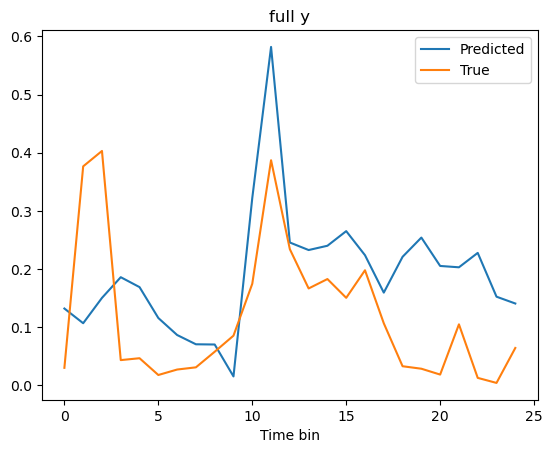

In [82]:
reshaped = amp_pred_train.reshape(trials_train, time_bins)
# reshaped = inp_train.reshape(trials_train, time_bins)
# plot
# plt.plot(np.mean(reshaped, axis=0), label='Predicted')
# plt.plot(np.mean(amp_train, axis=0), label='True')
trial_idx = np.random.randint(trials_train)
# trial_idx = 23
plt.plot(reshaped[trial_idx], label='Predicted')
plt.plot(amp_train[trial_idx], label='True')
plt.legend()
plt.xlabel('Time bin')
plt.title("full y")

# Train LR model for behavior prediction and plot weights for each neuron

In [ ]:
x_train = spikes_train.reshape(-1, spikes_train.shape[-1])
x_test = spikes_test.reshape(-1, spikes_test.shape[-1])
y_train, y_test = amp_train_flat, amp_test_flat

# x_train = spikes_train.reshape(spikes_train.shape[0], -1)
# x_test = spikes_test.reshape(spikes_test.shape[0], -1)
# y_train, y_test = y_stim_train, y_stim_test

# linear regression
reg = LinearRegression().fit(x_train, y_train)
# reg = LogisticRegression(penalty='l1', C=1, solver='liblinear').fit(x_train, y_train)
# accuracies
train_accuracy = reg.score(x_train, y_train)
test_accuracy = reg.score(x_test, y_test)
print("Train accuracy: {}, Test accuracy: {}".format(train_accuracy, test_accuracy))
# plot weights for each neuron
coeffs = abs(reg.coef_)
# plt.plot(coeffs)
# reshape into time x neurons
# coeffs = coeffs.reshape(-1, emissions_dim).mean(axis=0)
print(coeffs)
plt.plot(coeffs)

# plt.xlabel('Neuron')
# plt.ylabel('Weight')
# plt.title('Weights for each neuron')
# # sort weights in descending order of absolute value and print them
sorted_weights = np.argsort(coeffs)[::-1]
print(sorted_weights)

In [ ]:
sorted_weights, coeffs[sorted_weights]

In [67]:
# do pca on spikes
from sklearn.decomposition import PCA
print(spikes.shape)
pca = PCA(n_components=14)
pca.fit(spikes.reshape(-1, spikes.shape[-1]))
# print cumulative explained variance
print(pca.explained_variance_ratio_.cumsum())


(161, 25, 14)
[0.2137065  0.36637171 0.49408404 0.59507549 0.6761101  0.74583337
 0.79989737 0.84814995 0.89266791 0.92905986 0.96471139 0.98870062
 0.99722254 1.        ]
